In [ ]:
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

# Загрузка датасета

Подгрузим исходный датасет и разархивируем его.

In [ ]:
!curl -k https://files.inria.fr/aerialimagelabeling/getAerial.sh | bash

In [ ]:
image = Image.open('/content/AerialImageDataset/train/images/austin1.tif')
image

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
image.size

(5000, 5000)

# Подготовка датасета

Обозначим директорию на гугл диске, где будут лежать данные.

In [ ]:
BASE_DIR = Path('/content/gdrive/MyDrive/final project dls/dataset')
BASE_DIR

Создадим папки для тренировочных и для тестовых данных.

In [ ]:
TRAIN_DIR = BASE_DIR.joinpath("train")
TRAIN_DIR

In [ ]:
TEST_DIR = BASE_DIR.joinpath("test/")
TEST_DIR

In [ ]:
TRAIN_DIR.mkdir()
TEST_DIR.mkdir()

Для тренировочных создадим две папки: для изобрадений и для Ground truth масок. Для тренировочных только папку для изображений.

In [ ]:
TRAIN_IMG_DIR = TRAIN_DIR.joinpath("images/")
TRAIN_GT_DIR = TRAIN_DIR.joinpath("gt/")
TEST_IMG_DIR = TEST_DIR.joinpath("images/")

In [ ]:
TRAIN_GT_DIR.mkdir()
TRAIN_IMG_DIR.mkdir()
TEST_IMG_DIR.mkdir()

Функция для разбиения изображения на подизображения. Исходные изображения имеют размер 5000 * 5000, поделим их на подизображения размером 250 * 250.

In [ ]:
# генератор для разбиения изображения image на подизображения размером sub_img_size
def sub_img_generator(image, sub_img_size):
    for row in range(image.size[1]//sub_img_size[1]):
        for col in range(image.size[0]//sub_img_size[0]):
            yield image.crop(box=(
                    row * sub_img_size[1],
                    col * sub_img_size[0],
                    (row + 1) * sub_img_size[1],
                    (col + 1) * sub_img_size[0]
                )
            )


Пути для исходных изображений и масок, который были разахивированы.

In [ ]:
p = Path('/content/AerialImageDataset/train/images')
p_gt = Path('/content/AerialImageDataset/train/gt')

Отсортируем, чтобы получить список путей изображний и соотвествующих им масок.

In [ ]:
train_val_img_files = sorted(list(p.rglob('*.tif')))
train_val_img_files

In [ ]:
train_val_gt_files = sorted(list(p_gt.rglob('*.tif')))
train_val_gt_files

Выделим имена изображений без пути и расширения.

In [ ]:
train_val_labels = [path.stem for path in train_val_img_files]
train_val_labels

Т.к. изображений много, выделим по 10 изображений для каждого из пяти регионов.

In [ ]:
regions = 5
all_tiles = 36
cut_tiles = 10
cut_train_val_labels = []
for i in range(regions):
    cut_train_val_labels += train_val_labels[i*all_tiles:i*all_tiles+cut_tiles]
cut_train_val_labels

Выполним разбиение изображений и соответствующих масок и сохраним их в созданные директории. Также добавим проверку информативности маски, чтобы сохранялись только те пары, где класс застройки занимает более одного процента изображения.

In [ ]:
def is_informative_gt(gt, threshold=0.01):
    return (np.array(gt) > 0).mean() > threshold

In [ ]:
for filename in cut_train_val_labels:
    image = Image.open(f'{p}/{filename}.tif')
    gt = Image.open(f'{p_gt}/{filename}.tif')
    sub_gen = sub_img_generator(image, (250,250))
    sub_gt_gen = sub_img_generator(gt, (250,250))
    for i, (subimg, subgt) in enumerate(zip(sub_gen, sub_gt_gen)):
        if is_informative_gt(subgt):
            subimg.save(f'{TRAIN_IMG_DIR}/{filename}_{i}.png')
            subgt.save(f'{TRAIN_GT_DIR}/{filename}_{i}.png')

Посмотрим на какое-нибудь сохраненное изображение или маску и убедимся, что все в порядке.

In [ ]:
image = Image.open('/content/gdrive/MyDrive/final project dls/dataset/train/gt/austin13_351.png')

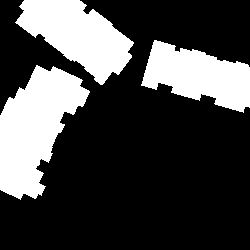

In [ ]:
image